In [1]:
%load_ext autoreload
%autoreload 2

import sys
import tqdm
import torch
import numpy as np
import pandas as pd
import scanpy as sc
import torch.nn as nn
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt

from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from transformers import T5Tokenizer, T5EncoderModel
from pytorch_lightning import Trainer

sys.path.append('..')
from pLMtrainer.dataloader import FrustrationDataset, FrustrationDataModule
from pLMtrainer.models import FrustrationFNN, FrustrationCNN

torch.set_float32_matmul_precision('medium')
parquet_path = "../data/frustration/v3_frustration.parquet.gzip"

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pq.read_table(parquet_path).to_pandas()
df.head(2)

,proteinID,full_seq,res_seq,res_idx,frst_idx,frst_class,set,cath_T_id
0,AF-A0A009EQP3-F1-model_v4_TED02,MKESLRLRLDQLSDRHEELTALLADVEVISDNKRFRQLSREHNDLT...,"[Y, L, E, I, R, A, G, T, G, G, D, E, A, A, I, ...","[111, 112, 113, 114, 115, 116, 117, 118, 119, ...","[0.235, 1.632, -0.844, 1.365, 0.282, -0.384, 0...","[9, 6, 11, 6, 9, 10, 9, 9, 9, 11, 12, 13, 9, 8...",train,3.30.70
1,AF-A0A009F754-F1-model_v4_TED02,MANPAQLVRHKLLNTFFSRHSVWFACITIAVIFTIFHIGYEPRYIY...,"[R, I, L, I, G, N, E, Q, C, T, Q, P, Y, S, A, ...","[164, 165, 166, 167, 168, 169, 170, 171, 172, ...","[-1.068, 1.469, -0.317, 1.098, -0.663, -0.771,...","[12, 6, 10, 7, 11, 11, 7, 10, 3, 9, 13, 11, 9,...",train,3.20.20


In [4]:
df = df.sample(n=100, random_state=42).reset_index(drop=True)
df.head(1)

,proteinID,full_seq,res_seq,res_idx,frst_idx,frst_class,set,cath_T_id
0,AF-A0A3Q0FE68-F1-model_v4_TED02,MSSQPLSPSNFKDLFDSVEAFLFDCDGVIWKGDELIQGVPKTLQML...,"[F, A, A, A, M, Y, L, K, A, K, D, F, P, S, Q, ...","[87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 9...","[0.941, -0.244, 0.494, 0.393, 0.553, -0.163, 1...","[7, 10, 8, 9, 8, 10, 6, 12, 9, 13, 6, 7, 8, 10...",train,3.40.50


In [6]:
device = "mps"
#pLM_model = "../data/prostT5"
pLM_model = "../data/protT5"
prefix_prostT5 = "<AA2fold>"
max_seq_length = 400 + 1
tokenizer = T5Tokenizer.from_pretrained(pLM_model, do_lower_case=False, max_length=max_seq_length)
encoder = T5EncoderModel.from_pretrained(pLM_model).to(device)

In [13]:
frust_avail = []
embeddings = []
res_labels = []
frst_val = []
frst_class = []

for row in tqdm.tqdm(df.iterrows()):
    idx = min(len(row[1]["full_seq"]), max_seq_length)

    full_seq = [prefix_prostT5 + " " + " ".join(seq) for seq in [row[1]["full_seq"]]]  # Add spaces between amino acids and prefix
    ids = tokenizer.batch_encode_plus(full_seq, 
                                    add_special_tokens=True, 
                                    max_length=max_seq_length,
                                    padding="max_length",
                                    truncation="longest_first",
                                    return_tensors='pt'
                                    ).to(device)
        
    with torch.no_grad():
        embedding_rpr = encoder(
            ids.input_ids, 
            attention_mask=ids.attention_mask
        )
    emb = embedding_rpr.last_hidden_state[0, 1:idx,]
    embeddings.append(emb)
    res_labels.append(list(row[1]["full_seq"])[:idx-1])

    frsts = torch.zeros((len(row[1]["full_seq"])), dtype=torch.bool)
    frsts[row[1]["res_idx"]] = True
    frust_avail.append(frsts[:idx-1])
    vals = np.zeros((len(row[1]["full_seq"])))
    vals[:] = np.nan
    vals[row[1]["res_idx"]] = row[1]["frst_idx"]
    frst_val.append(vals[:idx-1])
    classes = np.zeros((len(row[1]["full_seq"])), dtype=object)
    classes[:] = "non-frustrated"
    classes[row[1]["res_idx"]] = row[1]["frst_class"]
    frst_class.append(classes[:idx-1])
    break

0it [00:00, ?it/s]


In [14]:
adata = sc.AnnData(X=torch.cat(embeddings, dim=0).cpu().numpy())
adata.obs['frustration'] = torch.cat(frust_avail, dim=0).cpu().numpy()
adata.obs['residue'] = np.concatenate(res_labels, axis=0)
adata.obs['frst_val'] = np.concatenate(frst_val, axis=0)
adata.obs['frst_class'] = np.concatenate(frst_class, axis=0)
adata.obs['frst_class'] = adata.obs['frst_class'].astype('category')
adata.obs

,frustration,residue,frst_val,frst_class
0,False,M,NaN,non-frustrated
1,False,S,NaN,non-frustrated
2,False,S,NaN,non-frustrated
3,False,Q,NaN,non-frustrated
4,False,P,NaN,non-frustrated
...,...,...,...,...
303,False,V,NaN,non-frustrated
304,False,V,NaN,non-frustrated
305,False,C,NaN,non-frustrated
306,False,T,NaN,non-frustrated


In [15]:
sc.pp.neighbors(adata,)

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/scanpy/neighbors/__init__.py:586: UserWarning: You’re trying to run this on 1024 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


In [16]:
sc.tl.umap(adata)

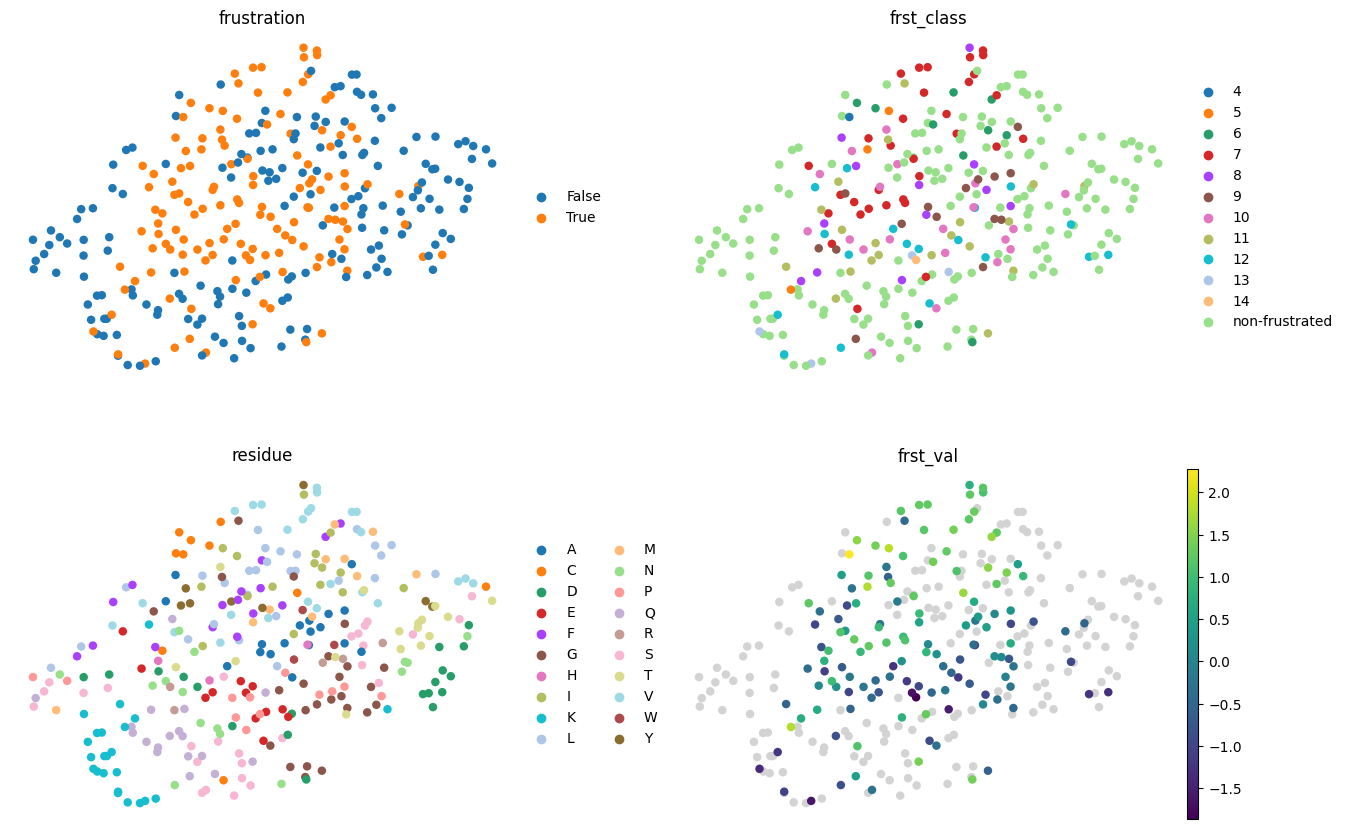

In [21]:
sc.pl.umap(adata, color=['frustration', 'frst_class', 'residue', 'frst_val'], wspace=0.2, ncols=2, frameon=False, size=150)

In [23]:
a = torch.randint(0, 10, (3, 4))

In [24]:
a.half()

tensor([[0., 0., 6., 7.],
        [2., 2., 5., 9.],
        [1., 5., 7., 0.]], dtype=torch.float16)

In [26]:
a.float().dtype

torch.float32

In [2]:
adata = sc.read("../notebooks/frustration_adata_700_1k.h5ad")
adata

AnnData object with n_obs × n_vars = 420065 × 1024
    obs: 'frustration', 'residue', 'frst_val', 'frst_class'
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

<Axes: ylabel='Count'>

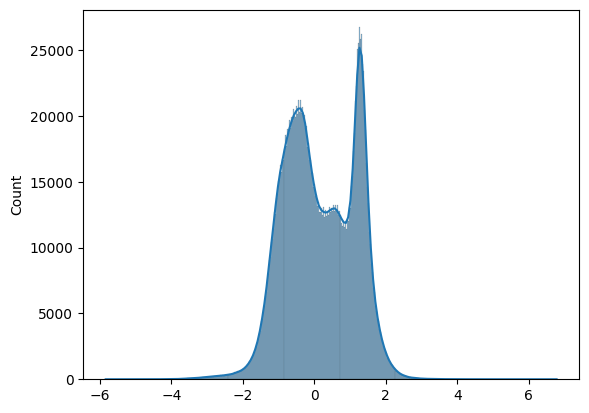

In [ ]:
sns.histplot(adata.obs["frst_val"].values, kde=True)

In [3]:
adata_frst = adata[adata.obs['frustration'] == True, :].copy()
adata_frst

AnnData object with n_obs × n_vars = 185285 × 1024
    obs: 'frustration', 'residue', 'frst_val', 'frst_class'
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
del(adata_frst.uns["pca"], adata_frst.uns["umap"], adata_frst.uns["neighbors"], adata_frst.obsm["X_pca"], adata_frst.obsm["X_umap"], adata_frst.varm["PCs"], adata_frst.obsp["connectivities"], adata_frst.obsp["distances"])

<Axes: xlabel='frst_class'>

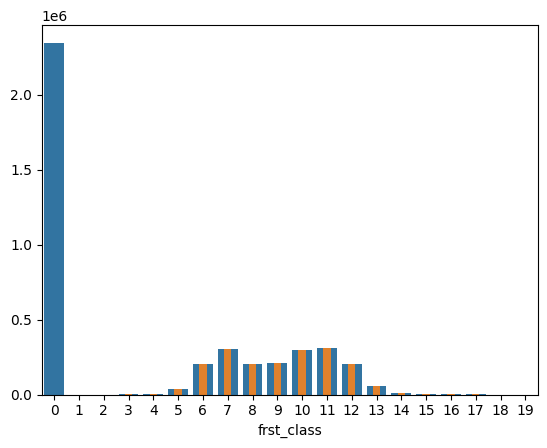

In [22]:
sns.barplot(x=adata.obs["frst_class"].value_counts().index, y=adata.obs["frst_class"].value_counts().values)
sns.barplot(x=adata_frst.obs["frst_class"].value_counts().index, y=adata_frst.obs["frst_class"].value_counts().values, width=0.3)

<Axes: xlabel='residue'>

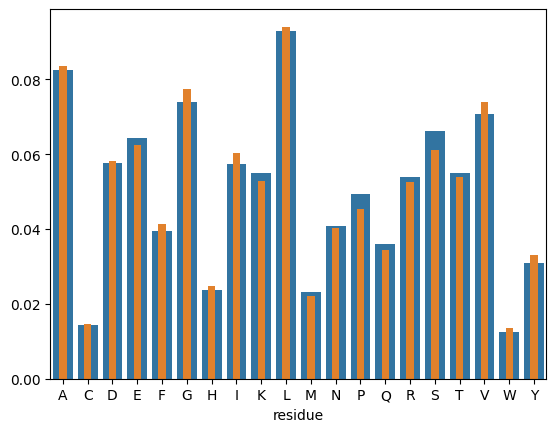

In [15]:
sns.barplot(x=adata.obs["residue"].value_counts().index, y=adata.obs["residue"].value_counts(normalize=True).values)
sns.barplot(x=adata_frst.obs["residue"].value_counts().index, y=adata_frst.obs["residue"].value_counts(normalize=True).values, width=0.3)

In [ ]:
sns.barplot(x=adata.obs["residue"].value_counts().index, y=adata.obs["residue"].value_counts(normalize=True).values)

In [11]:
property_dict = {
    'A': 'hydrophobic', 'V': 'hydrophobic', 'I': 'hydrophobic', 'L': 'hydrophobic', 'M': 'moderate',
    'F': 'hydrophobic', 'Y': 'hydrophobic', 'W': 'hydrophobic',
    'R': 'positive', 'H': 'positive', 'K': 'positive',
    'D': 'negative', 'E': 'negative',
    'S': 'hydrophilic', 'T': 'hydrophilic', 'N': 'hydrophilic', 'Q': 'hydrophilic',
    'C': 'special', 'G': 'special', 'P': 'special'
}

In [ ]:
adata.obs['residue_property'] = adata.obs['residue'].map(property_dict)

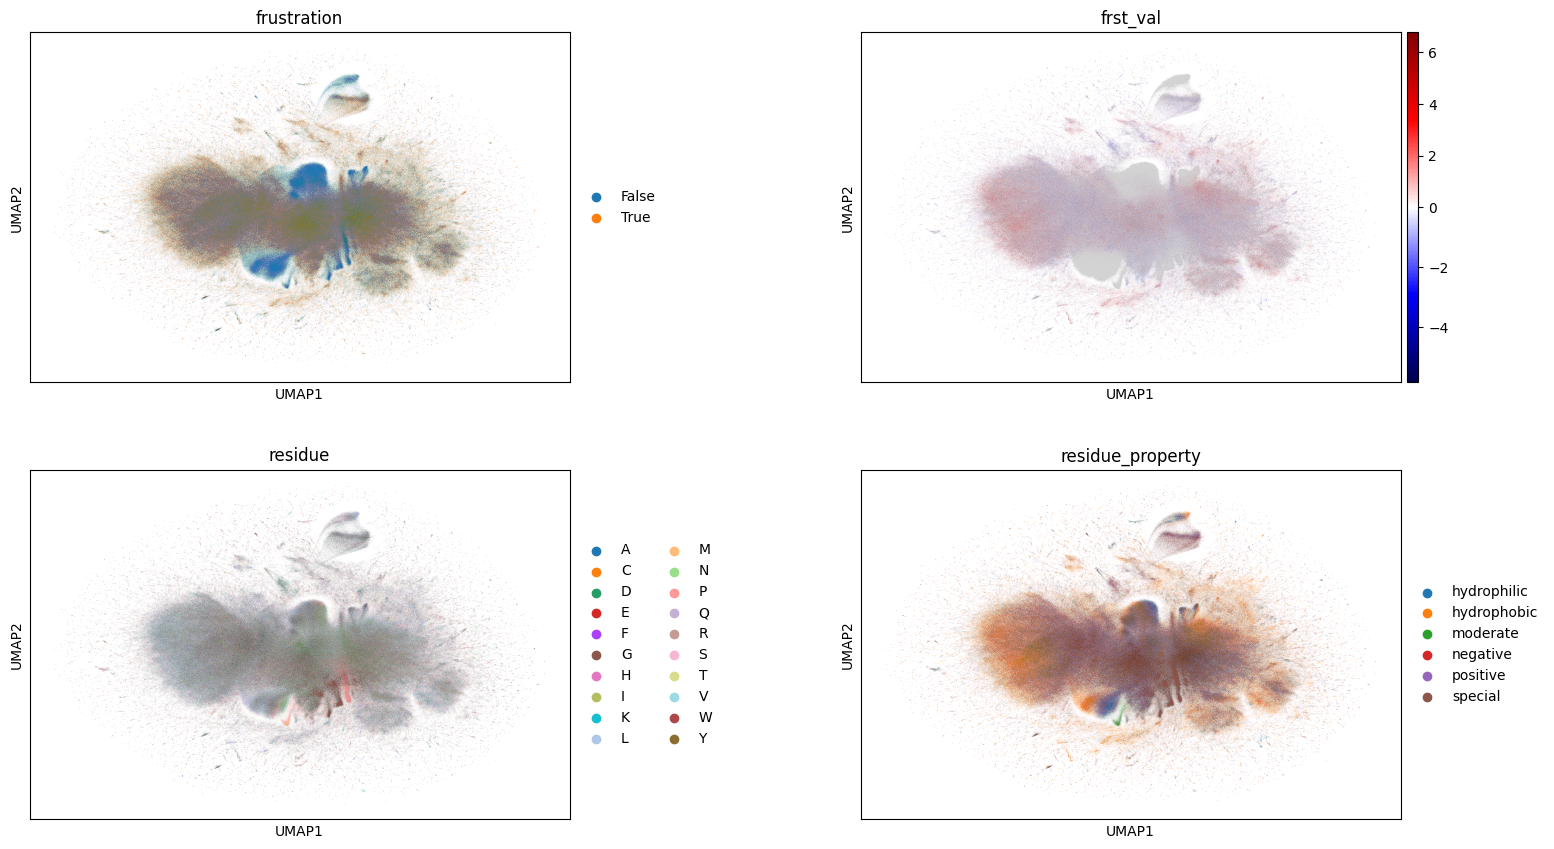

In [8]:
sc.pl.umap(adata, color=['frustration', 'frst_val', 'residue', 'residue_property'], ncols=2, wspace=0.4, cmap='seismic', vcenter=0,) #palette="tab20")

In [7]:
adata_frst

AnnData object with n_obs × n_vars = 185285 × 1024
    obs: 'frustration', 'residue', 'frst_val', 'frst_class'

In [8]:
sc.pp.neighbors(adata_frst,)

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/scanpy/neighbors/__init__.py:586: UserWarning: You’re trying to run this on 1024 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


In [9]:
sc.tl.umap(adata_frst)

In [12]:
adata_frst.obs['residue_property'] = adata_frst.obs['residue'].map(property_dict)

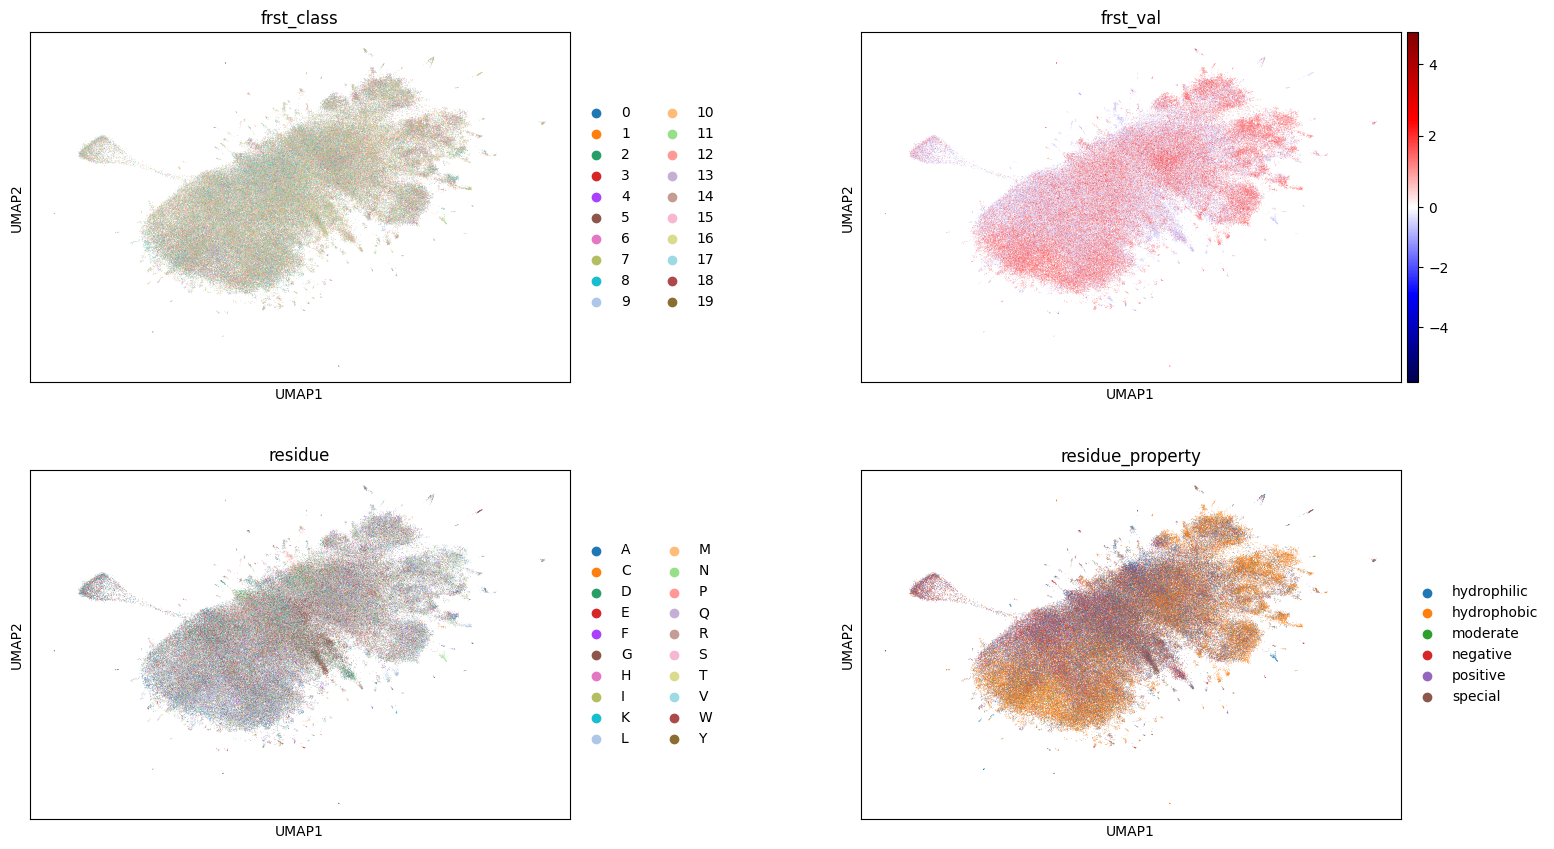

In [13]:
sc.pl.umap(adata_frst, color=['frst_class', 'frst_val', 'residue', 'residue_property'], ncols=2, wspace=0.4, cmap='seismic', vcenter=0,) #palette="tab20")

In [56]:
mask = torch.zeros((len(row[1]["full_seq"])), dtype=torch.bool)
mask[row[1]["res_idx"]] = True
mask = mask[:max_seq_length-1]
mask

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True])

In [45]:
embeddings[0,mask,:].shape
    

torch.Size([13, 1024])

In [33]:
embeddings.shape

torch.Size([1, 99, 1024])

In [59]:
len(list(row[1]["full_seq"])[:100])

100

In [49]:
np.array(list(row[1]["full_seq"]))[row[1]["res_idx"]]

array(['F', 'A', 'A', 'A', 'M', 'Y', 'L', 'K', 'A', 'K', 'D', 'F', 'P',
       'S', 'Q', 'N', 'K', 'V', 'Y', 'V', 'I', 'G', 'G', 'E', 'G', 'I',
       'L', 'E', 'E', 'L', 'Q', 'L', 'A', 'G', 'I', 'T', 'A', 'F', 'G',
       'G', 'P', 'H', 'S', 'L', 'V', 'Q', 'E', 'D', 'A', 'N', 'K', 'T',
       'I', 'D', 'L', 'K', 'Q', 'N', 'C', 'F', 'V', 'E', 'H', 'D', 'K',
       'S', 'V', 'G', 'A', 'V', 'V', 'V', 'G', 'I', 'D', 'P', 'N', 'I',
       'N', 'Y', 'Y', 'K', 'L', 'Q', 'Y', 'G', 'T', 'L', 'C', 'I', 'R',
       'E', 'N', 'P', 'G', 'C', 'L', 'F', 'I', 'A', 'T', 'N', 'R', 'D',
       'A', 'V', 'G', 'H', 'M', 'T', 'A', 'L', 'Q', 'E', 'W', 'P', 'G',
       'A', 'G', 'C', 'M', 'V', 'A', 'A', 'I', 'C', 'G', 'S', 'T', 'Q',
       'K', 'E', 'P', 'V', 'V', 'V'], dtype='<U1')

In [54]:
a = np.array([[1,2,3], [4,5,6]])
b = np.array([[7,8,9], [10,11,12]])
c = np.concatenate([a, b], axis=0)

In [55]:
c

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

In [25]:
data_module = FrustrationDataModule(parquet_path=parquet_path, batch_size=10, max_seq_length=100, num_workers=1, persistent_workers=True, sample_size=1000,)

In [26]:
early_stop = EarlyStopping(monitor="val_loss",
                           patience=5,
                           mode='min',
                           verbose=True)
checkpoint = ModelCheckpoint(monitor="val_loss",
                             dirpath="./checkpoints",
                             filename=f"debug",
                             save_top_k=1,
                             mode='min',
                             save_weights_only=True)
logger = CSVLogger("./checkpoints", name="debug_logs")

In [27]:
model = FrustrationCNN(input_dim=1024, 
                       hidden_dim=32, 
                       output_dim=22, 
                       dropout=0.15, 
                       max_seq_length=100,
                       precision="half",
                       pLM_model="../data/ProstT5", 
                       prefix_prostT5="<AA2fold>",
                       no_label_token=0)


Using half precision


In [28]:
trainer = Trainer(accelerator='auto', # gpu
                  devices=-1, # 4 for one node on haicore
                  #strategy='ddp',
                  max_epochs=2,
                  logger=logger,
                  log_every_n_steps=10, # 50 for haicore default
                  callbacks=[early_stop, checkpoint],
                  precision="16-mixed",
                  gradient_clip_val=1,
                  enable_progress_bar=True,
                  deterministic=False, # for reproducibility disable on cluster 
                  #num_sanity_val_steps=0,
                  #accumulate_grad_batches=2, # if batch size gets too small --> test on H100/A100
                  )

trainer.fit(model, datamodule=data_module)

Using 16bit Automatic Mixed Precision (AMP)
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loaded 1000 samples from ../data/frustration/v3_frustration.parquet.gzip
Created train/val/test masks
Initialized res_idx_mask and frst_vals tensors
Populated res_idx_mask and frst_vals tensors
Created train dataset
Created val dataset
Created test dataset
Train/Val/Test split: 899/35/66 samples


/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /Users/janleusch/Documents/phd/pLMtrainer/pLMtrainer/notebooks/checkpoints exists and is not empty.
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | T5EncoderModel   | 1.2 B  | eval 
1 | CNN         | Sequential       | 234 K  | train
2 | mse_loss_fn | MSELoss          | 0      | train
3 | ce_loss_fn  | CrossEntropyLoss | 0      | train
---------------------------------------------------------
1.2 B     Trainable params
0         Non-trainable params
1.2 B     Total params
4,833.595 Total estimated mod

Configuring optimizers
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:527: Found 439 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Epoch 0: 100%|██████████| 90/90 [01:33<00:00,  0.97it/s, v_num=21, train_loss_step=2.210, val_loss=2.330, train_loss_epoch=2.660]

Metric val_loss improved. New best score: 2.334


Epoch 1: 100%|██████████| 90/90 [01:39<00:00,  0.91it/s, v_num=21, train_loss_step=2.120, val_loss=2.240, train_loss_epoch=2.240]

Metric val_loss improved by 0.092 >= min_delta = 0.0. New best score: 2.242
`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 90/90 [01:41<00:00,  0.89it/s, v_num=21, train_loss_step=2.120, val_loss=2.240, train_loss_epoch=2.240]


In [29]:
trainer.test(model, datamodule=data_module)

Loaded 1000 samples from ../data/frustration/v3_frustration.parquet.gzip
Created train/val/test masks
Initialized res_idx_mask and frst_vals tensors
Populated res_idx_mask and frst_vals tensors
Created train dataset
Created val dataset
Created test dataset
Train/Val/Test split: 899/35/66 samples


/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


torch.Size([10, 100]) torch.Size([10, 100])
Testing DataLoader 0: 100%|██████████| 7/7 [00:07<00:00,  0.93it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_ce_loss        │     1.746380090713501     │
│         test_loss         │    2.2817649841308594     │
│       test_mse_loss       │    0.5353850722312927     │
└───────────────────────────┴───────────────────────────┘

[{'test_mse_loss': 0.5353850722312927,
  'test_ce_loss': 1.746380090713501,
  'test_loss': 2.2817649841308594}]

In [35]:
model.test_dict["regr_preds"].shape

(66, 100)

In [36]:
model.save_preds_targets()

In [38]:
test_dict = np.load("./preds_targets.npz")
test_dict["regr_preds"].shape  

(66, 100)

In [17]:
mask = [True] * 10 + [False] * 90
model.all_preds[:, mask, :].shape

(66, 10, 2)

In [14]:
a = torch.tensor([[1,2], [3,4],[5,6]]).flatten(-1)
a

tensor([[1, 2],
        [3, 4],
        [5, 6]])